# Self-supervision

На протяжении последнего десятилетия одним из главных рецептов успеха для различных задач Компьютерного Зрения было получение визуальных представлений применяя методы обучения с учителем для ImageNet классификации. Затем эти представления или веса модели использовали для инициализации других задач Компьютерного Зрения для которых существует нехватка тренировочных данных.

Однако получение аннотаций для набора данных масштаба ImageNet занимает очень много времени и это достаточно дорого. К примеру: для разметки 14 миллионов изображений из ImageNet потребовалось примерно 22 человеко-года.

Поэтому сообщество начало искать альтернативные способы разметки, такие как хэштеги для изображений в социальных сетях, GPS локации или подходы самостоятельного обучения, когда метка является свойством самой выборки данных.

Особенно остро встают две проблемы:
1. Обучение разметке для редких классов требует гигантского объема тренировочных данных.
2. ImageNet может быть плохой стартовой позицией для определенных доменов. Так, изображения МРТ совсем не похоже на то, что размечено внутри ImageNet. Модель, конечно, выучит фильтры для границ, углов и т.п., но не будет иметь представления о более абстрактных концепциях.



Подход *self-supervised learning* состоит в использовании автоматически получаемых меток для некоторого набора данных. С примерами SSL мы уже сталкивались:
1. Предсказание пропущенных слов (токенов) в Masked Language Models (BERT).
2. Предсказание следующего слова в Causal Language Models (GPT).

Но сегодня поговорим об изображениях. В них есть два основных подхода:

1. *Contrastive Learning*
2. *Non-contrastive Methods*

Сможете сразу догадаться, в чем их суть?

## Contrastive Learning на примере SimCLR

Тут все очень просто:

Одни картинки после аугментаций должны оставаться похожими, а разные -- разными.

<img src ="https://amitness.com/images/simclr-general-architecture.png" width="700">

Для метода необходим большой набор негативных примеров. Это значительно замедляет обучение. 

Контрастивные методы также очень чувствительны к структуре датасета. Часто они "идут по легкому пути", выхватывая бесполезную информацию из объектов. 

Так, для картинок SimCLR очень часто обращает внимание только на распределение цветов, не определяя ничего семантического на изображении.Из-за этого надо очень внимательно подходить к выбору аугментаций на рисунках.

## Non-contrastive methods. Bootrstrap Your Own Latent (BYOL)

BYOL избавляется от негативной выборки SimCLR. Важно не то, насколько разные получатся репрезентации для разных объектов, а то, насколько близкие получатся репрезентации одних и тех же.

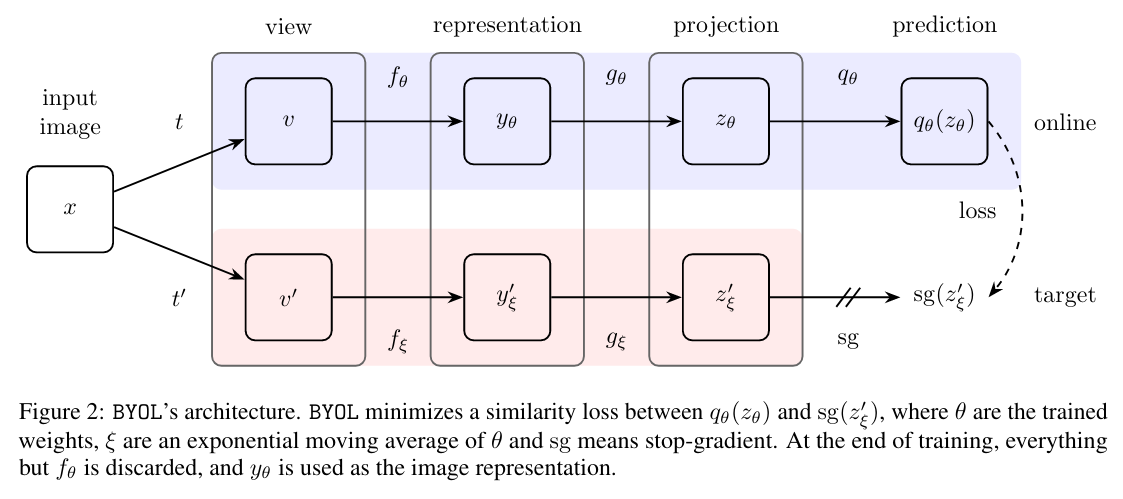


В методе используются две сети:

- Учитель
- Студент

Обеим сетям на вход подаются объекты, полученные модификацией одного исходного примера. Это могут быть:
1. Два предложения из одного текста
2. Два куска одного изображения

То есть, нам нужен процесс, порождающий пары объектов, которые мы будем считать похожими.

Учитель не обучается, он просто производит репрезентацию объекта, а целью студента является приблизиться к этой репрезентации.

Хитрость в том, что веса учителя обновляются каждую эпоху с помощью весов студента:

$$\theta^{i+1}_{teacher} = (1-\epsilon)\theta^{i}_{teacher} + ϵ\theta^{i}_{student}$$

Тонкость в том, чтобы подобрать удачный $ϵ$. Слишком большой будет приводить к тривиальным решениям (учитель станет слишком похож на ученика). Слишком маленький приведет к долгому обучению, а может даже вообще привести к невозможности обучения.

Dino по сути своей является BYOL.

# Домашка на четыре недели

Предлагаю вам датасет со снимками глазного дна. Цель -- научить модель определять тяжесть диабетической ретинопатии по снимку.

В файле train.csv дана классификация снимков по следующим классам:

- 0 - Normal
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferative 

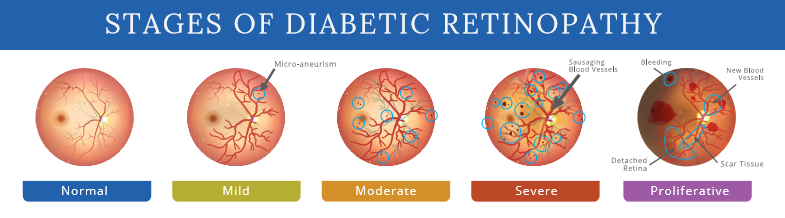



От вас EDA и модель на CNN.

Что буду искать в работах:
- Состав классов в данных (кого больше, кого меньше)
- Код для обучения модели
    - Разбиение на train/val/test
    - Обоснование использования предобученных моделей, если они будут
    - Нужные трансформации изображений, причины выбора именно таких трансформаций
    - Выбор метрик и loss функции

[Diabetic Retinopathy dataset](https://drive.google.com/file/d/19ecWqNNk7zM8ULglXzX-VIqmCUxccd7H/view?usp=sharing)

# Библиотеки

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.utils.random import sample_without_replacement
import pandas as pd
%matplotlib inline
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch import nn
import torch.nn.functional as F
from IPython.display import clear_output
import torchvision

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cuda


# Подключение Google Disk

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ZIP_PATH = "/content/drive/MyDrive/images.zip"
DATA_PATH = "."

In [6]:
! unzip $ZIP_PATH -d  $DATA_PATH

Archive:  /content/drive/MyDrive/images.zip
   creating: ./images/
  inflating: ./images/345b1f0abbba.png  
  inflating: ./images/349f3c0ac83e.png  
  inflating: ./images/351e842842a2.png  
  inflating: ./images/352e4a939242.png  
  inflating: ./images/354b8911d6ed.png  
  inflating: ./images/357f02a779d7.png  
  inflating: ./images/358d2224de73.png  
  inflating: ./images/359bab5d784b.png  
  inflating: ./images/362c4a96cebb.png  
  inflating: ./images/365f8c01d994.png  
  inflating: ./images/367c7049929c.png  
  inflating: ./images/370f575adb23.png  
  inflating: ./images/383e72af1955.png  
  inflating: ./images/384db24ebbd7.png  
  inflating: ./images/384e6c915722.png  
  inflating: ./images/388f12e8df0b.png  
  inflating: ./images/393fa5a023a5.png  
  inflating: ./images/401fdfd0db07.png  
  inflating: ./images/404ede327e98.png  
  inflating: ./images/405b4f78658f.png  
  inflating: ./images/408ea9d5e082.png  
  inflating: ./images/415d5c5e785f.png  
  inflating: ./images/415f2d2bd

In [7]:
DATA_PATH = os.path.join(DATA_PATH, 'images')
CLASS_PATH = "/content/images.csv"

In [8]:
DATA_PATH

'./images'

In [9]:
! ls $DATA_PATH

000c1434d8d7.png  4289af3afbd2.png  810ed108f5b7.png  be521870a0ea.png
001639a390f0.png  4294a14c656a.png  8114d6a160df.png  be68322c7223.png
0024cdab0c1e.png  42985aa2e32f.png  812d5adafaf2.png  be6cbf6e5b10.png
002c21358ce6.png  42a67337fa8e.png  81371b0c01ad.png  be7bc89f5fec.png
005b95c28852.png  42a850acd2ac.png  81704925f759.png  be7f791a7877.png
0083ee8054ee.png  42af7282349b.png  8185ce1cdcef.png  be8697eb2078.png
0097f532ac9f.png  42b08dca9b2f.png  81914ceb4e74.png  beb00fa6e7c9.png
00a8624548a9.png  42b93b574f23.png  8191ae701985.png  beb2ad14fd2d.png
00b74780d31d.png  42b9c1977681.png  81b0a2651c45.png  bebb3f167654.png
00cb6555d108.png  42c65af5ab16.png  81bc03e2ff2b.png  bebfbd907cac.png
00cc2b75cddd.png  42cc993f23a9.png  81d79d53ed7b.png  bec0acd539b2.png
00e4ddff966a.png  4318b6adeb97.png  8201cab8322d.png  bed8296c8dfe.png
00f6c1be5a33.png  4350a1b2f3cb.png  82088c6734e6.png  beeca5f14618.png
0104b032c141.png  435414ccccf7.png  821789e9053f.png  bf18ff30a8f6.png
0124df

# Exploratory data analysis 

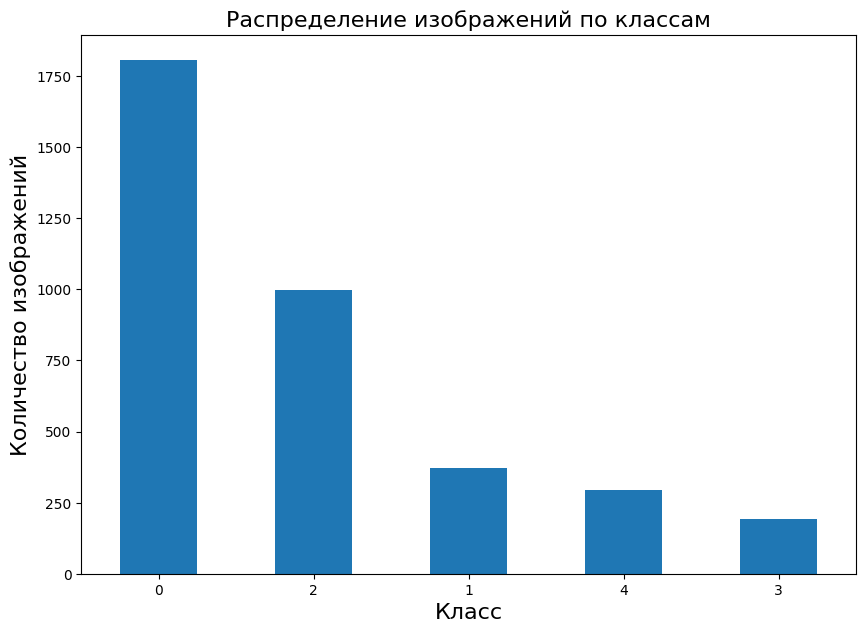

In [10]:
df_im_classes = pd.read_csv(CLASS_PATH)

plt.figure(figsize=(10,7))
df_im_classes.diagnosis.value_counts().plot.bar(rot=0);
plt.xlabel('Класс', fontsize=16)
plt.ylabel('Количество изображений', fontsize=16)
plt.title('Распределение изображений по классам', fontsize=16)
plt.show()

*Видно, что присутствует некоторая несбалансированность в классах. Это можно исправить несколькими способами (балансировка классов входит в один из глобальных шагов "прокачивания" будущей модели). Например, можно использовать аугментацию для картинок малых классов (таким образом, мы увеличим количество изображений для обучения), также можно не учитывать некоторые изображения наиболее популярных классов (таким образом, количество изображений для сетки уменьшится), можно задавать веса для лосса и т.д. В базовом варианте будем тренировать сетку без балансировки, далее по возможности будем пробовать использовать что-то из вышеперечисленного для балансировки.*

In [11]:
df_im_classes.head(15)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
5,0083ee8054ee,4
6,0097f532ac9f,0
7,00a8624548a9,2
8,00b74780d31d,2
9,00cb6555d108,1


*Посмотрим на картинки разных классов:*

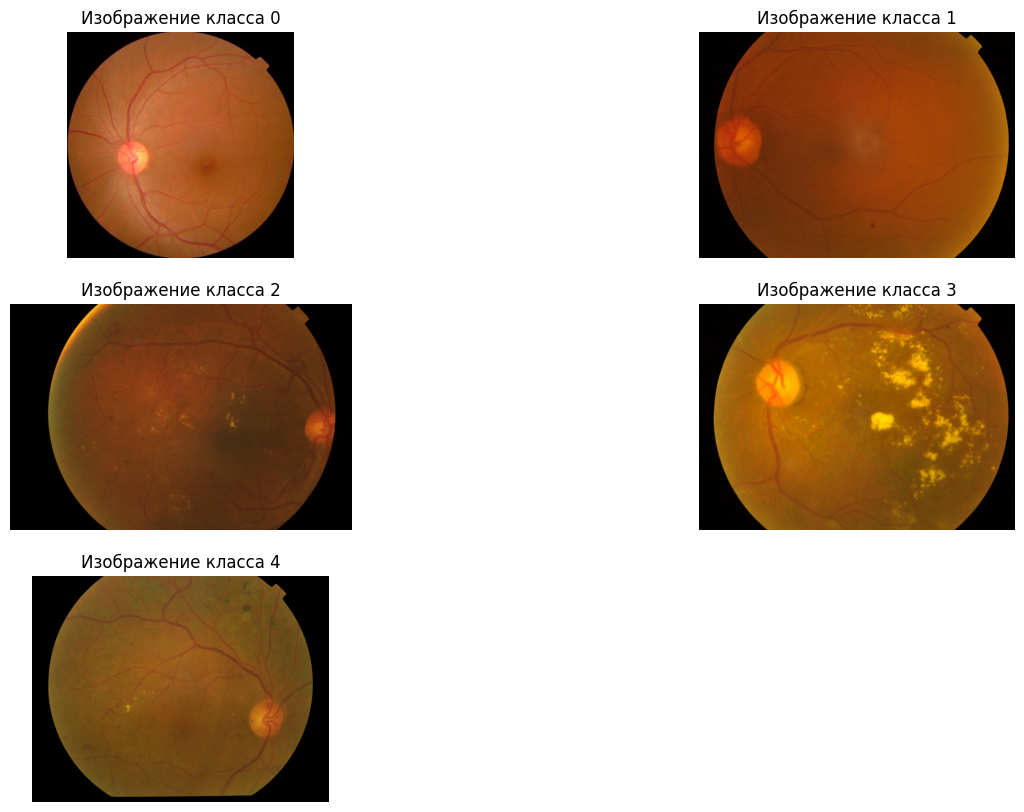

In [12]:
plt.figure(figsize=(16, 10))
plt.subplot(3, 2, 1)
path_to_img = os.path.join(DATA_PATH, "002c21358ce6.png")
image = plt.imread(path_to_img)
plt.imshow(image)
plt.title('Изображение класса 0')
plt.axis("off");

plt.subplot(3, 2, 2)
path_to_img = os.path.join(DATA_PATH, "0024cdab0c1e.png")
image = plt.imread(path_to_img)
plt.imshow(image)
plt.title('Изображение класса 1')
plt.axis("off");

plt.subplot(3, 2, 3)
path_to_img = os.path.join(DATA_PATH, "000c1434d8d7.png")
image = plt.imread(path_to_img)
plt.imshow(image)
plt.title('Изображение класса 2')
plt.axis("off");

plt.subplot(3, 2, 4)
path_to_img = os.path.join(DATA_PATH, "0104b032c141.png")
image = plt.imread(path_to_img)
plt.imshow(image)
plt.title('Изображение класса 3')
plt.axis("off");

plt.subplot(3, 2, 5)
path_to_img = os.path.join(DATA_PATH, "0083ee8054ee.png")
image = plt.imread(path_to_img)
plt.imshow(image)
plt.title('Изображение класса 4')
plt.axis("off");

In [13]:
image.shape

(512, 670, 3)

*Можно заметить, что изображения имеют разные размеры в пикселях. Это говорит о том, что их необходимо будет изменить и подогнать под одинаковый размер, от этого может напрямую зависеть итоговый результат после обучения сетки.*

# Основной код обучения

### Разделение на train/val/test

In [14]:
df_im_classes

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In [15]:
# Папка с картинами для тренировки
TRAIN_DIR = "/content/images_train"
os.makedirs(TRAIN_DIR, exist_ok=True)

# Папка с картинами для валидации
VAL_DIR = "/content/images_val"
os.makedirs(VAL_DIR, exist_ok=True)

# Папка с картинками для теста
TEST_DIR = "/content/images_test"
os.makedirs(TEST_DIR, exist_ok=True)

In [16]:
classes = [0, 1, 2, 3, 4]
DATA_PATH = "/content/images"

In [17]:
for number_of_class in classes:
    # Создаём директории классов внутри каждой train/val/test папки
    os.makedirs(os.path.join(TRAIN_DIR, f'class_{number_of_class}'), exist_ok=True)
    os.makedirs(os.path.join(VAL_DIR, f'class_{number_of_class}'), exist_ok=True)
    os.makedirs(os.path.join(TEST_DIR, f'class_{number_of_class}'), exist_ok=True)

    # Выделяем часть картинок для валидации и теста
    # Выбираем класс по таблице df_im_classes
    # После этого делим каждый набор картинок для каждого из классов на трейн, валидацию и тест
    # Деление происходит так: train = 60%, val = 20%, test = 20%
    df_im_classes_curr = df_im_classes[df_im_classes['diagnosis'] == number_of_class]
    train_im, validate_im, test_im = \
       np.split(df_im_classes_curr.sample(frac=1, random_state=0), [int(0.6*len(df_im_classes_curr)), int(0.8*len(df_im_classes_curr))])

    print(f'Количество картинок для класса {number_of_class} по каждой подвыборке: train={len(train_im)}, val={len(validate_im)}, test={len(test_im)}')
    
    # Сохраняем тренировочную, валидационную и тестовую выборки в соответствующие директории
    for image_filename in train_im['id_code']:
        source = os.path.join(DATA_PATH, image_filename + '.png')
        destination = os.path.join(TRAIN_DIR, f'class_{number_of_class}', image_filename + '.png')
        shutil.copy(source, destination)
        os.remove(source)
    
    for image_filename in validate_im['id_code']:
        source = os.path.join(DATA_PATH, image_filename + '.png')
        destination = os.path.join(VAL_DIR, f'class_{number_of_class}', image_filename + '.png')
        shutil.copy(source, destination)
        os.remove(source)

    for image_filename in test_im['id_code']:
        source = os.path.join(DATA_PATH, image_filename + '.png')
        destination = os.path.join(TEST_DIR, f'class_{number_of_class}', image_filename + '.png')
        shutil.copy(source, destination)
        os.remove(source)

Количество картинок для класса 0 по каждой подвыборке: train=1083, val=361, test=361
Количество картинок для класса 1 по каждой подвыборке: train=222, val=74, test=74
Количество картинок для класса 2 по каждой подвыборке: train=599, val=200, test=200
Количество картинок для класса 3 по каждой подвыборке: train=115, val=39, test=39
Количество картинок для класса 4 по каждой подвыборке: train=177, val=59, test=59


### Трансформации изображений

In [18]:
train_dat = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=torchvision.transforms.ToTensor())
images_shape_x = []
images_shape_y = []
for im in train_dat:
    images_shape_x.append(im[0].shape[1])
    images_shape_y.append(im[0].shape[2])

In [19]:
print(f'Размеры картинок в датасете (в пикселях): по x - {sorted(list(set(images_shape_x)))}, по y - {sorted(list(set(images_shape_y)))}')

Размеры картинок в датасете (в пикселях): по x - [512], по y - [512, 623, 670, 677, 678, 683, 713, 763, 770, 771]


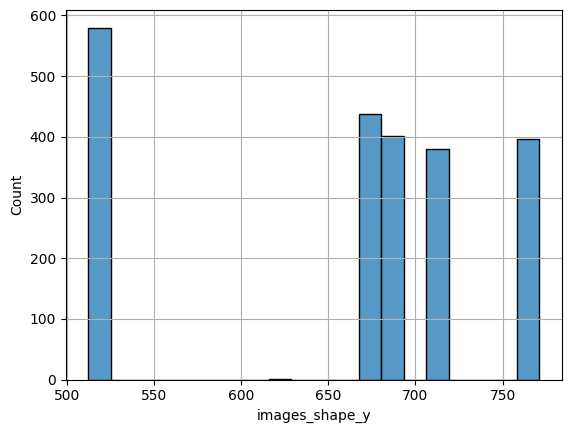

In [20]:
plt.plot(figsize=(10, 6))
sns.histplot(images_shape_y, bins=20, label='images_shape_y')
plt.xlabel('images_shape_y')
plt.grid()

Видно, что картинок примерно одинаковое количество по всем группам, поэтому можно просто взять что-то близкое к среднему по всем размерам.

In [ ]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), \
                                              torchvision.transforms.Resize([512, int(np.mean(images_shape_y) - 17)])])


In [ ]:
train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform=transformer)

In [ ]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 2196
    Root location: /content/images_train
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[512, 640], interpolation=bilinear, max_size=None, antialias=warn)
           )

In [ ]:
val_dataset

Dataset ImageFolder
    Number of datapoints: 733
    Root location: /content/images_val
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[512, 640], interpolation=bilinear, max_size=None, antialias=warn)
           )

In [22]:
def plot_learning_curves(history):

    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [23]:
def train(model, criterion,optimizer, train_batch_gen,val_batch_gen,num_epochs=50):
  
    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)
            
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [ ]:
batch_size = 10

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### Baseline

Все изображения приведены к размеру 512 на 640 пикселей, т.е. теперь размеры (512, 640, 3).  
Начнём с простой линейной нейросетки, вдруг сразу всё и так сработает :)

In [ ]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # входное количество признаков = высота * ширина * кол-во каналов картинки
        # 64 нейрона в первом слое
        self.linear1 = nn.Linear(3 * 512 * 640, 64)
        # 5 нейронов во втором слое
        self.linear2 = nn.Linear(64, 5)
        
    def forward(self, x):
        x = self.linear1(nn.Flatten()(x))
        x = self.linear2(nn.ReLU()(x))
        return x

Используем стандартный кросс-энтропийный лосс, в качестве оптимизатора пока возьмём SGD.

Epoch 10 of 10 took 77.549s
  training loss (in-iteration): 	1.292609
  validation loss (in-iteration): 	1.290653
  training accuracy: 			49.35 %
  validation accuracy: 			49.41 %


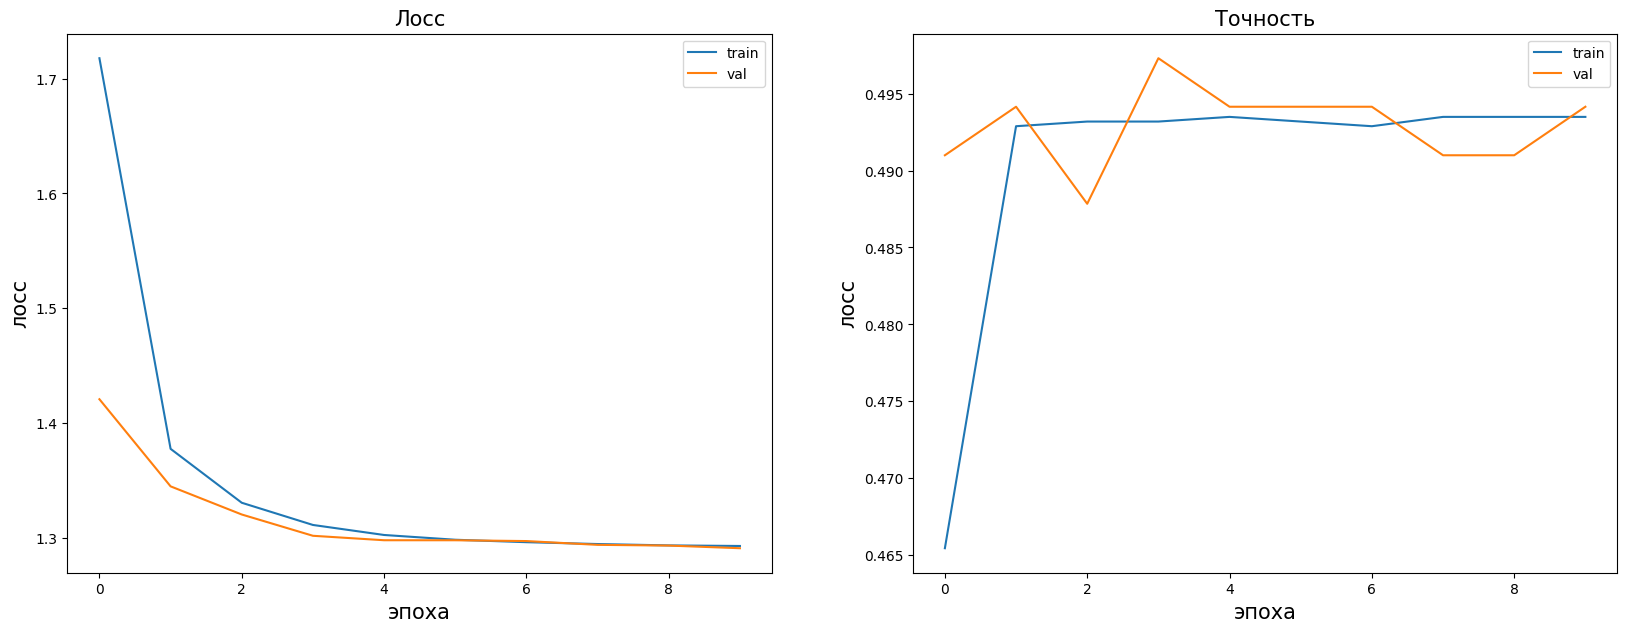

In [ ]:
model = LinearModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

### Convolutional neural network

### Первая итерация

Первая сетка выглядит так:  
Сначала (512, 640, 3) -> (508, 636, 16) после конволюции (kernel_size=5), затем макспуллинг, который превращает (508, 636, 16) -> (254, 318, 16), после применяется нормировка по батчам и дропаут 20% нейронов + функция активации.  
Вторым слоем состоит из конволюции с ядром 3, то есть изменение (254, 318, 16) -> (252, 316, 32), пуллинга (252, 316, 32) -> (63, 79, 32), нормировки, дропаута, функции активации.  
После идёт полносвязный слой с дропаутом и ф-ей активации.

In [ ]:
class FirstConvNet(nn.Module):
    def __init__(self):
        super(FirstConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(16)
        self.droupout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.mp2 = nn.MaxPool2d(4)
        self.bn2 = nn.BatchNorm2d(32)
        self.droupout2 = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.fc3 = nn.Linear(63 * 79 * 32, 512)
        self.droupout3 = nn.Dropout(0.2)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 5)
                                
    def forward(self, x):
        layer1 = self.mp1(self.conv1(x))
        layer1 = self.relu1(self.droupout1(self.bn1(layer1)))
        
        layer2 = self.mp2(self.conv2(layer1))
        layer2 = self.relu2(self.droupout2(self.bn2(layer2)))
        
        out = self.flatten(layer2)
        out = self.relu3(self.droupout3(self.fc3(out)))
        out = self.fc4(out)
        return out

Epoch 10 of 10 took 92.842s
  training loss (in-iteration): 	0.600837
  validation loss (in-iteration): 	0.750215
  training accuracy: 			77.61 %
  validation accuracy: 			72.66 %


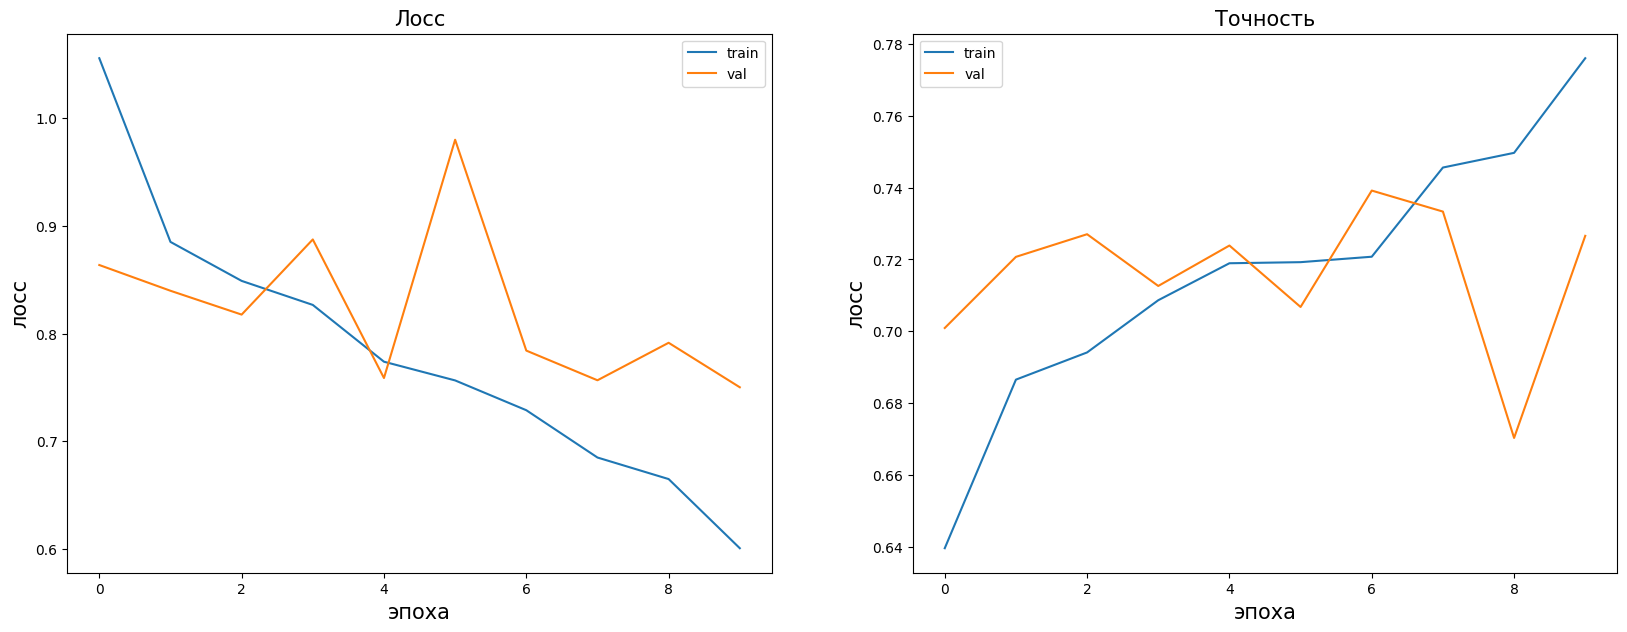

In [ ]:
model = FirstConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

### Вторая итерация

Теперь попробуем изменить размер картинок на меньший.

In [ ]:
autobot = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), \
                                              torchvision.transforms.Resize([512 // 2, int(np.mean(images_shape_y) - 17) // 2])])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=autobot)
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform=autobot)

In [ ]:
batch_size = 10

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Исходный размер (256, 320, 3).  
Изменения по слоям:  
1 слой - (256, 320, 3) -> (252, 316, 16) -> (126, 158, 16)  
2 слой - (126, 158, 16) -> (124, 156, 32) -> (62, 78, 32)


In [ ]:
class SecondConvNet(nn.Module):
    def __init__(self):
        super(SecondConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(16)
        self.droupout1 = nn.Dropout(0.2)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.mp2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(32)
        self.droupout2 = nn.Dropout(0.2)
        self.relu2 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.fc3 = nn.Linear(62 * 78 * 32, 512)
        self.droupout3 = nn.Dropout(0.2)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 5)
                                
    def forward(self, x):
        layer1 = self.mp1(self.conv1(x))
        layer1 = self.relu1(self.droupout1(self.bn1(layer1)))
        
        layer2 = self.mp2(self.conv2(layer1))
        layer2 = self.relu2(self.droupout2(self.bn2(layer2)))
        
        out = self.flatten(layer2)
        out = self.relu3(self.droupout3(self.fc3(out)))
        out = self.fc4(out)
        return out

Epoch 10 of 10 took 55.549s
  training loss (in-iteration): 	0.629589
  validation loss (in-iteration): 	0.770336
  training accuracy: 			76.74 %
  validation accuracy: 			69.55 %


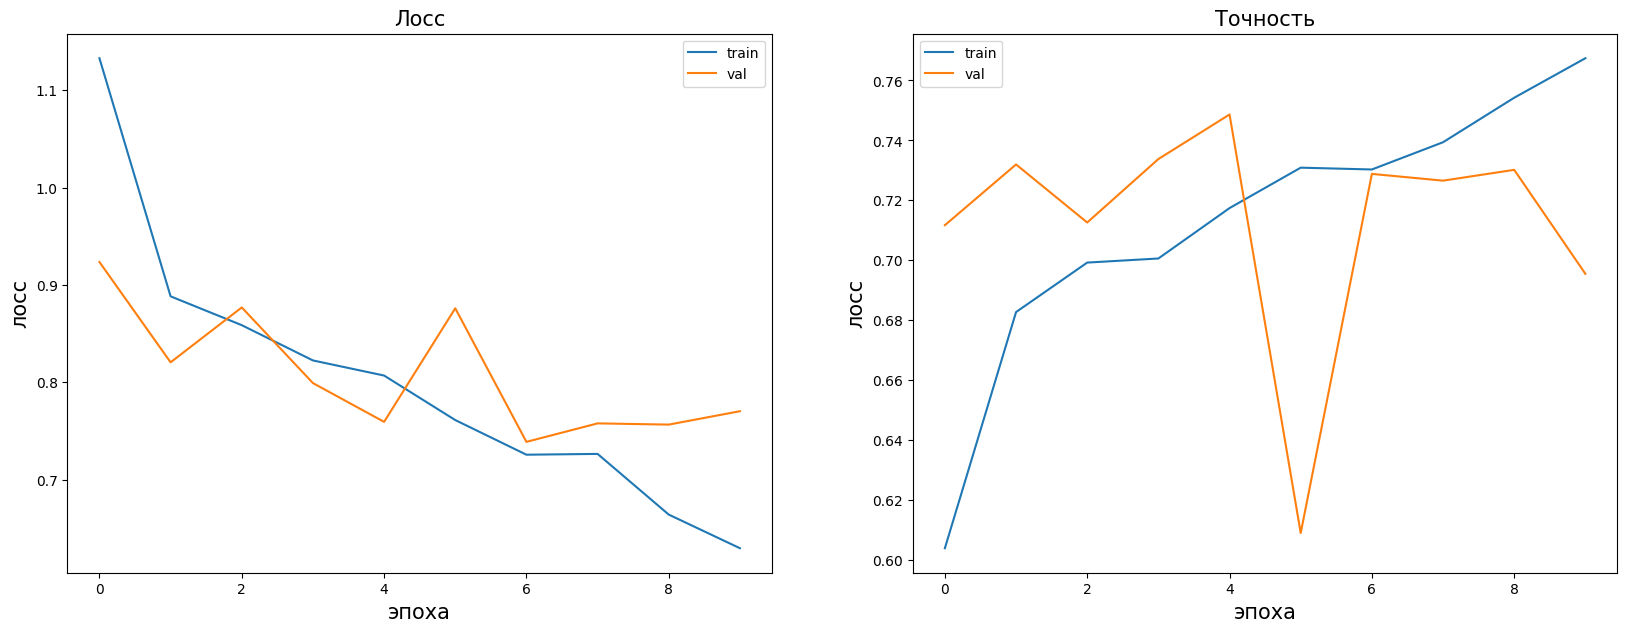

In [ ]:
model2 = SecondConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

model2, history = train(
    model2, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

Видно, что точность такой модели ниже при прочих равных, поэтому будем пробовать дальше.

### Третья итерация

Оставим размер 512 на 640 и увеличим размер батча.

In [24]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), \
                                              torchvision.transforms.Resize([512, int(np.mean(images_shape_y) - 17)])])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform=transformer)

batch_size = 50

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Epoch 10 of 10 took 91.667s
  training loss (in-iteration): 	0.533793
  validation loss (in-iteration): 	0.765949
  training accuracy: 			79.84 %
  validation accuracy: 			71.72 %


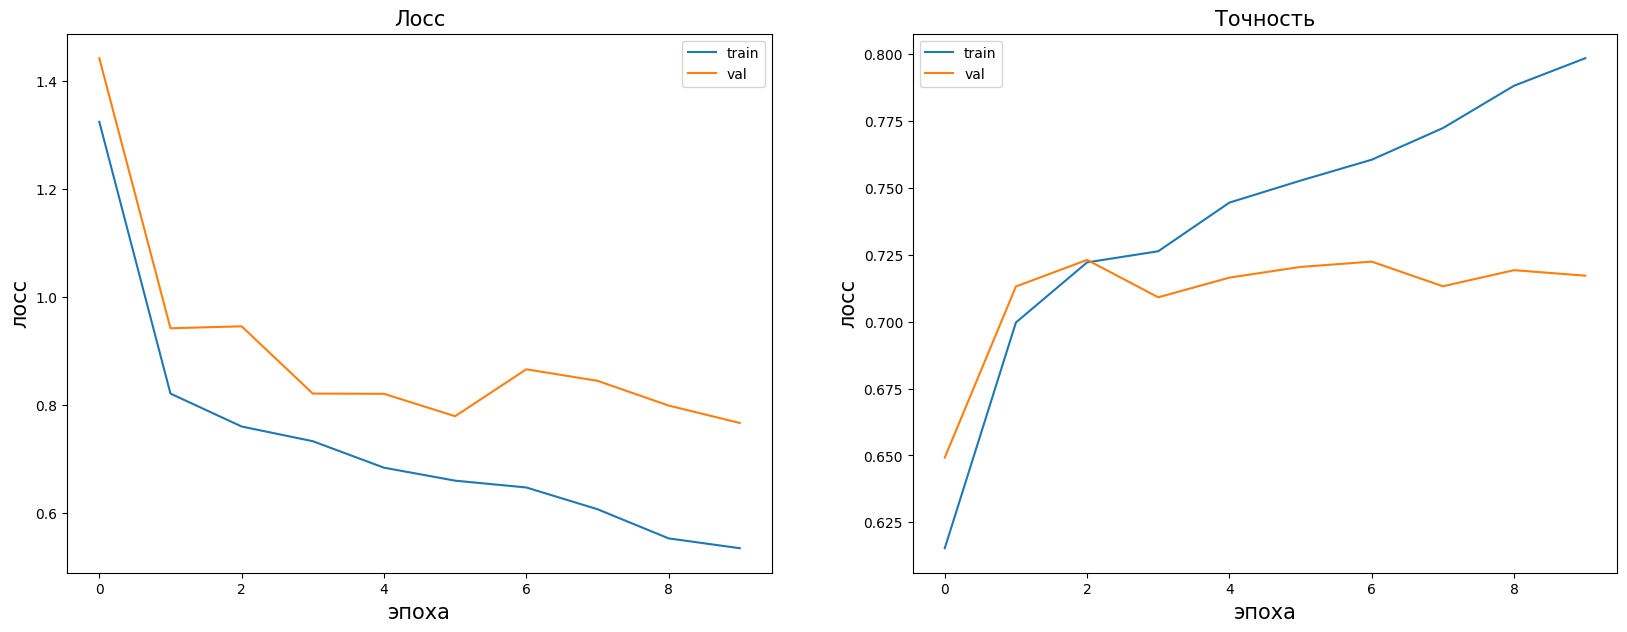

In [ ]:
model = FirstConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

В целом изменение размера батча ничего кардинально не поменяло. Далее пользуемся batch_size = 50.

### Четвёртая итерация

Теперь попробуем воспользоваться оптимизатором Adam.

Epoch 10 of 10 took 86.481s
  training loss (in-iteration): 	1.023953
  validation loss (in-iteration): 	0.963706
  training accuracy: 			58.56 %
  validation accuracy: 			65.11 %


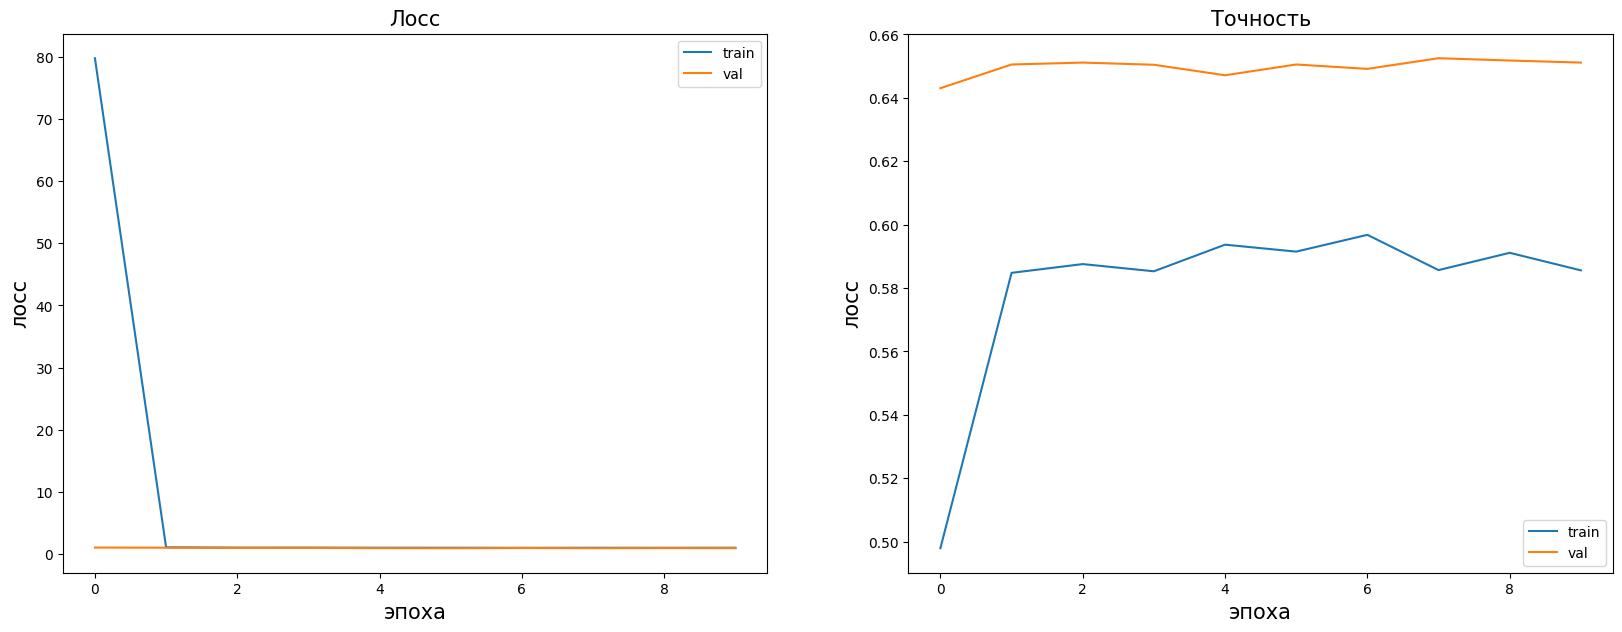

In [ ]:
model = FirstConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_Adam = torch.optim.Adam(model.parameters(), lr=0.01)

model, history = train(
    model, criterion, optimizer_Adam,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

Результат не улучшился.

### Пятая итерация

Попробуем сделать 3 слоя и поднять dropout_rate.  
Теперь архитектура выглядит так:  
1 слой - (512, 640, 3) -> (508, 636, 16) -> (254, 318, 16)  
2 слой - (254, 318, 16) -> (250, 314, 32) -> (125, 157, 32)  
3 слой - (125, 157, 32) -> (121, 153, 64) -> (60, 76, 64)  
Полносвязный слой


In [ ]:
class ThirdConvNet(nn.Module):
    def __init__(self):
        super(ThirdConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(16)
        self.droupout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.mp2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(32)
        self.droupout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(32, 64, 5)
        self.mp3 = nn.MaxPool2d(2)
        self.bn3 = nn.BatchNorm2d(64)
        self.droupout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.fc4 = nn.Linear(60 * 76 * 64, 512)
        self.droupout4 = nn.Dropout(0.3)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(512, 5)
                                
    def forward(self, x):
        layer1 = self.mp1(self.conv1(x))
        layer1 = self.relu1(self.droupout1(self.bn1(layer1)))
        
        layer2 = self.mp2(self.conv2(layer1))
        layer2 = self.relu2(self.droupout2(self.bn2(layer2)))
        
        layer3 = self.mp3(self.conv3(layer2))
        layer3 = self.relu3(self.droupout3(self.bn3(layer3)))

        out = self.flatten(layer3)
        out = self.relu4(self.droupout4(self.fc4(out)))
        out = self.fc5(out)
        return out

Epoch 10 of 10 took 103.636s
  training loss (in-iteration): 	0.632713
  validation loss (in-iteration): 	0.953316
  training accuracy: 			75.68 %
  validation accuracy: 			63.90 %


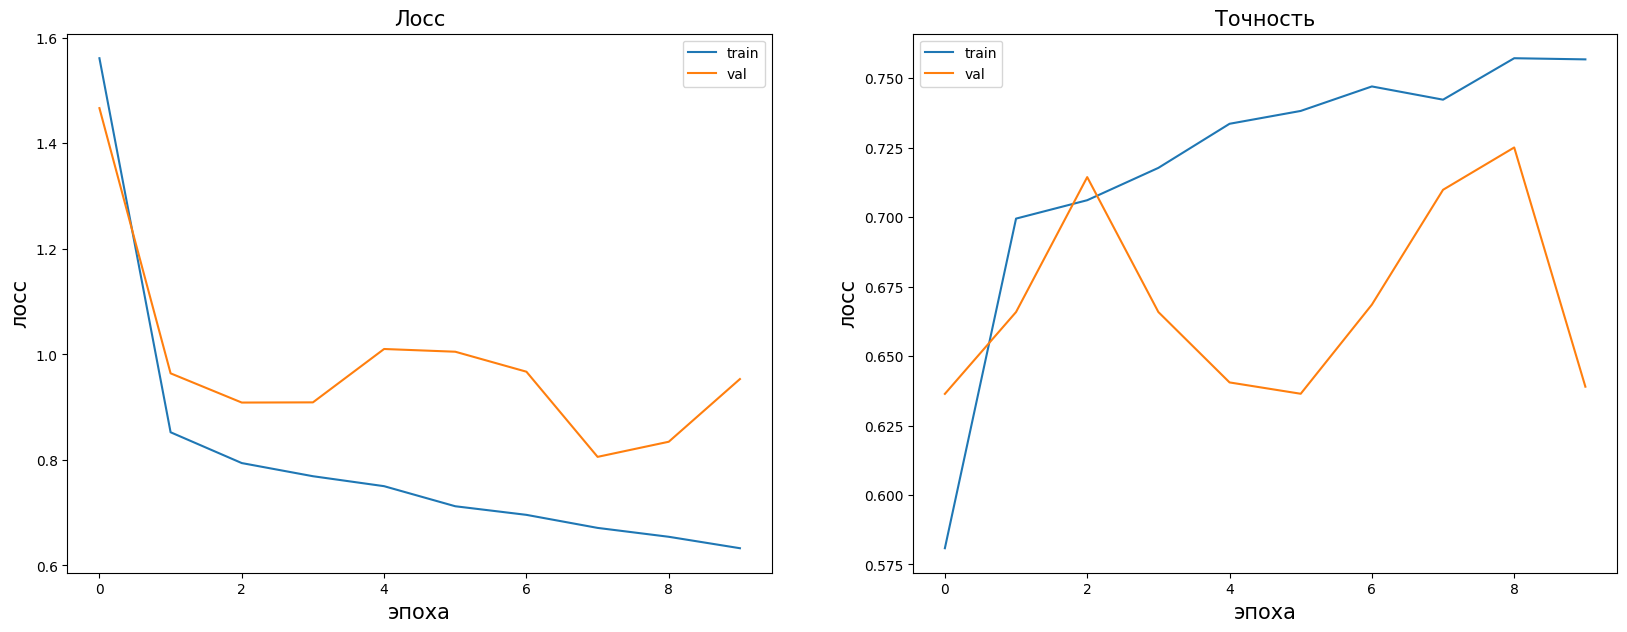

In [ ]:
model3 = ThirdConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.01)

model3, history = train(
    model3, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

Добавление слоя не изменило ситуацию.


### Шестая итерация

Попробуем воспользоваться stride и padding для улучшения результата сети.  
1 слой: (512, 640, 3) -> (256, 320, 16) -> (128, 160, 16)   
2 слой: (128, 160, 16) -> (64, 80, 32) -> (32, 40, 32)   
Полносвязный слой

In [25]:
class FourthConvNet(nn.Module):
    def __init__(self):
        super(FourthConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(16)
        self.droupout1 = nn.Dropout(0.3)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.mp2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(32)
        self.droupout2 = nn.Dropout(0.3)
        self.relu2 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.fc3 = nn.Linear(32 * 40 * 32, 512)
        self.droupout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 5)
                                
    def forward(self, x):
        layer1 = self.mp1(self.conv1(x))
        layer1 = self.relu1(self.droupout1(self.bn1(layer1)))
        
        layer2 = self.mp2(self.conv2(layer1))
        layer2 = self.relu2(self.droupout2(self.bn2(layer2)))
        
        out = self.flatten(layer2)
        out = self.relu3(self.droupout3(self.fc3(out)))
        out = self.fc4(out)
        return out

Epoch 10 of 10 took 76.287s
  training loss (in-iteration): 	0.627651
  validation loss (in-iteration): 	0.716235
  training accuracy: 			76.65 %
  validation accuracy: 			74.05 %


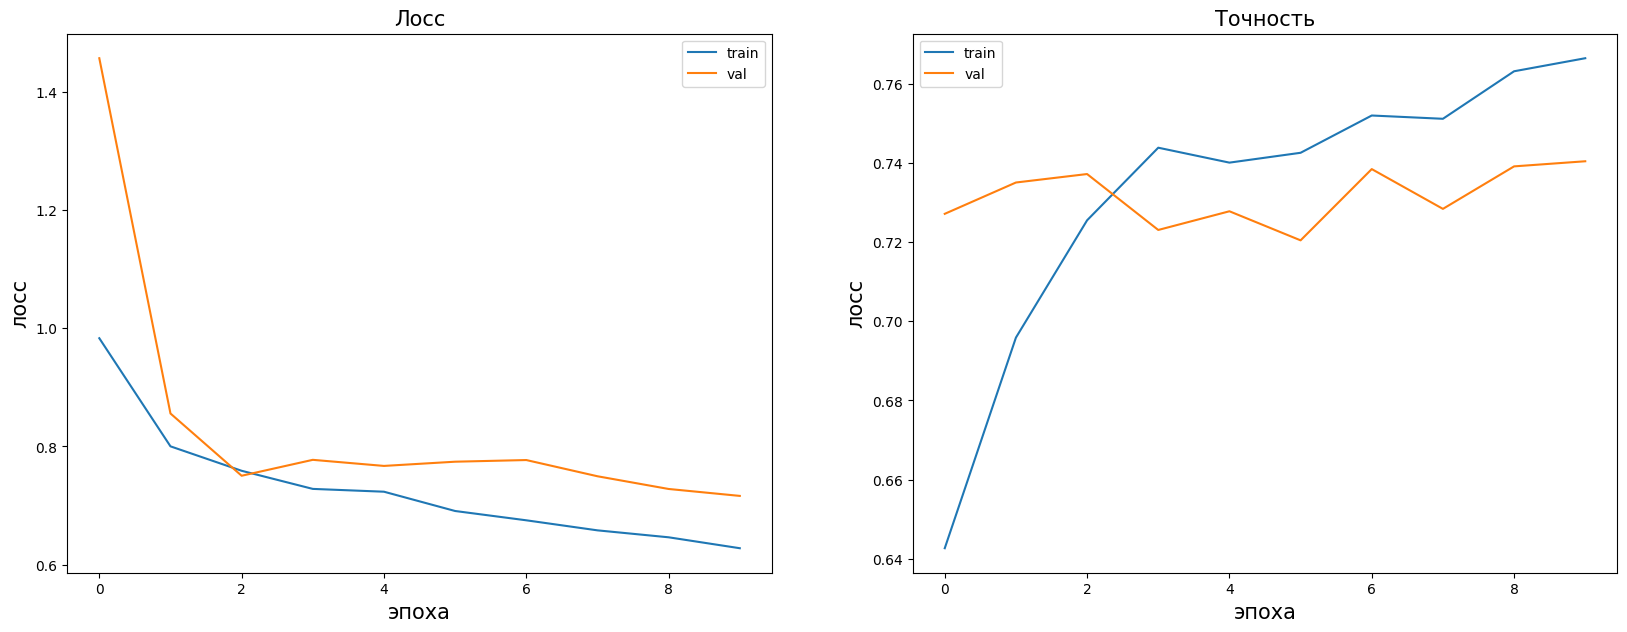

In [27]:
model4 = FourthConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(), lr=0.01)

model4, history = train(
    model4, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=10)

Видно, что удалось немного повысить точность на валидации. 

### Седьмая попытка


Заменим функции активации на leakyReLU и посмотрим, что получится :)

In [31]:
class FivthConvNet(nn.Module):
    def __init__(self):
        super(FourthConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 5, stride=2, padding=2)
        self.mp1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(16)
        self.droupout1 = nn.Dropout(0.3)
        self.relu1 = nn.LeakyReLU(0.1)
        
        self.conv2 = nn.Conv2d(16, 32, 5, stride=2, padding=2)
        self.mp2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(32)
        self.droupout2 = nn.Dropout(0.3)
        self.relu2 = nn.LeakyReLU(0.1)
        
        self.flatten = nn.Flatten()
        self.fc3 = nn.Linear(32 * 40 * 32, 512)
        self.droupout3 = nn.Dropout(0.3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(512, 5)
                                
    def forward(self, x):
        layer1 = self.mp1(self.conv1(x))
        layer1 = self.relu1(self.droupout1(self.bn1(layer1)))
        
        layer2 = self.mp2(self.conv2(layer1))
        layer2 = self.relu2(self.droupout2(self.bn2(layer2)))
        
        out = self.flatten(layer2)
        out = self.relu3(self.droupout3(self.fc3(out)))
        out = self.fc4(out)
        return out



Epoch 30 of 30 took 76.474s
  training loss (in-iteration): 	0.281035
  validation loss (in-iteration): 	0.741960
  training accuracy: 			90.98 %
  validation accuracy: 			73.38 %


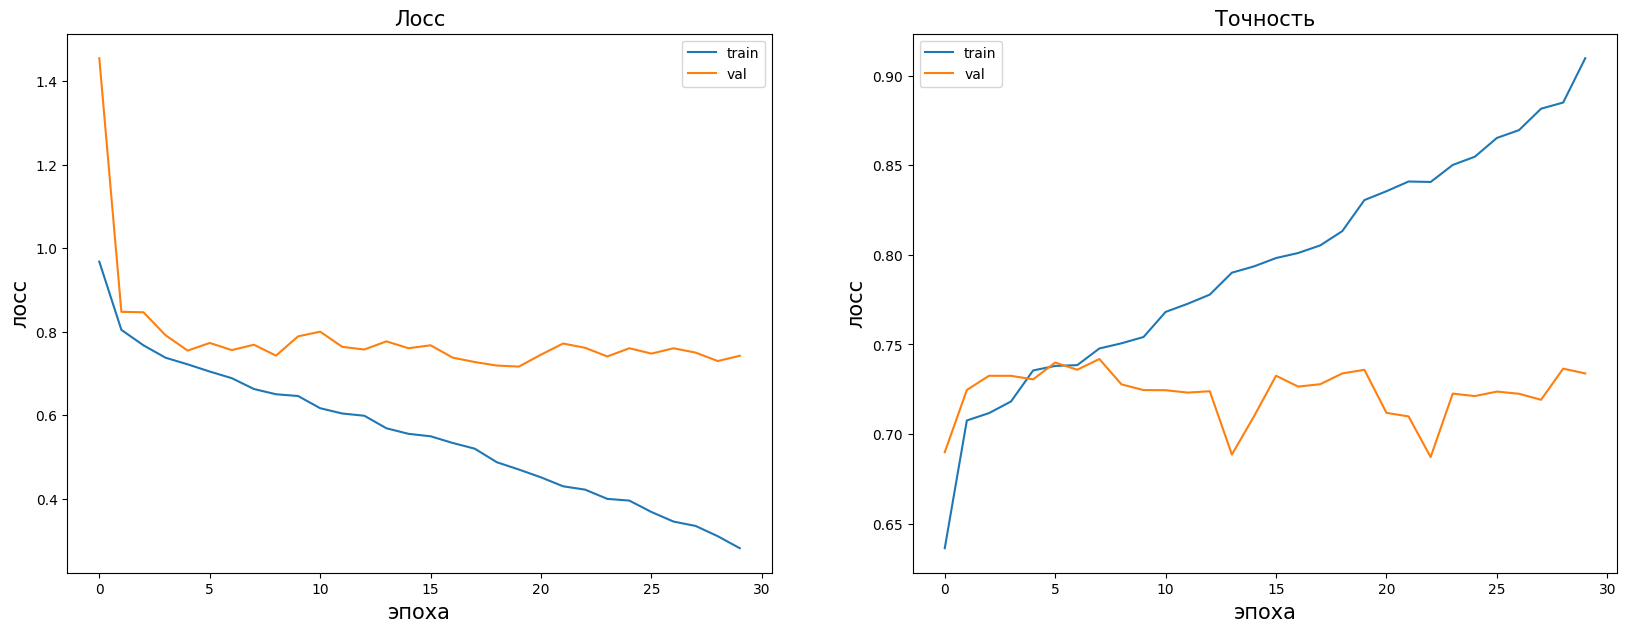

In [33]:
model5 = FourthConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model5.parameters(), lr=0.01)

model5, history = train(
    model5, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=30)

Сеть никак кардинально не изменилась.

### Лучшая модель

4 модель оказалась предпочтительной по точности, используем её.

In [28]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), \
                                              torchvision.transforms.Resize([512, int(np.mean(images_shape_y) - 17)])])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=transformer)
val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform=transformer)

batch_size = 50

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Epoch 30 of 30 took 77.317s
  training loss (in-iteration): 	0.329530
  validation loss (in-iteration): 	0.845355
  training accuracy: 			87.21 %
  validation accuracy: 			72.38 %


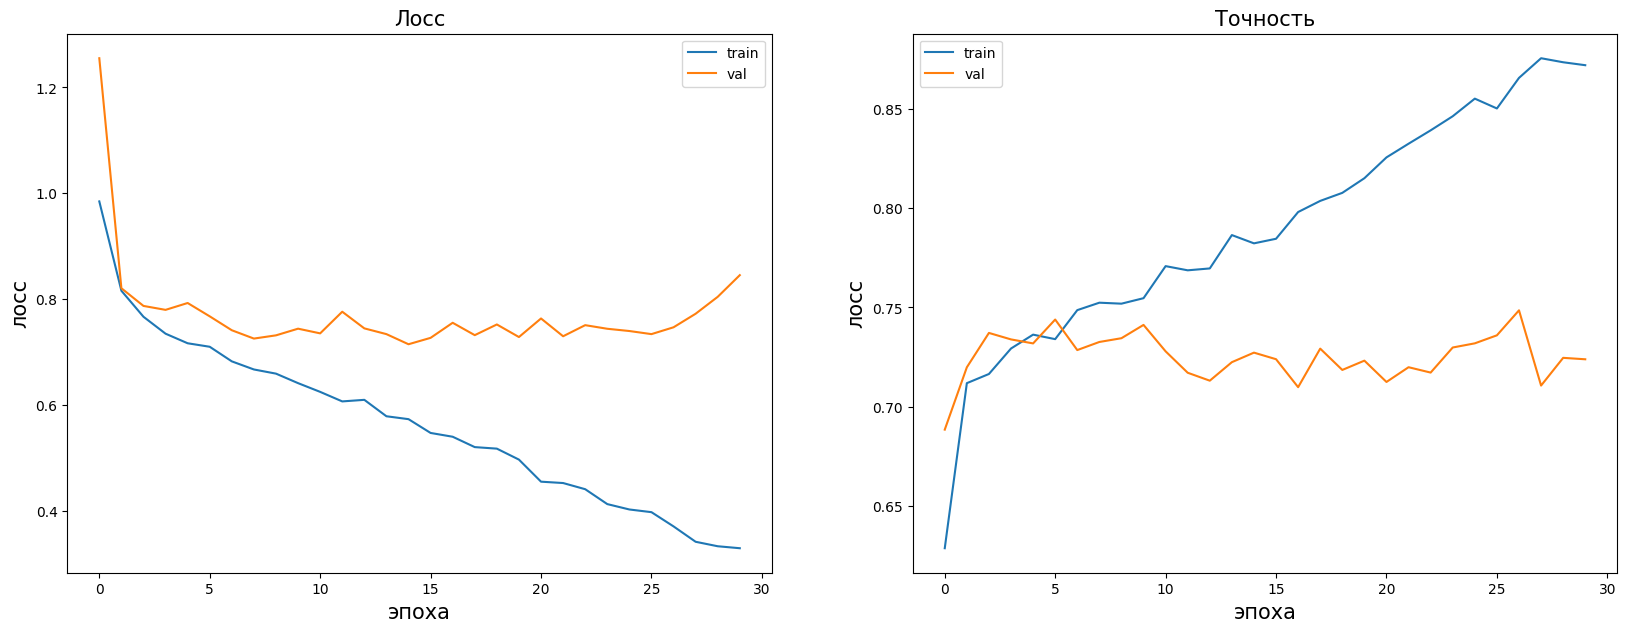

In [29]:
model_best = FourthConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_best.parameters(), lr=0.01)

model_best, history = train(
    model_best, criterion, optimizer,
    train_batch_gen, val_batch_gen,
    num_epochs=30)

**Вывод**: _При данной конфигурации модели на валидации имеем точность немногим выше 70 %. Это лучше, чем точность случайного или константного классификатора, а также лучше определённого выше baseline._


Используем выбранную модель на тестовой выборке картинок:

In [63]:
test_dataset = torchvision.datasets.ImageFolder(TEST_DIR, transform=transformer)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)
y_arr = np.array([])
y_pred_arr = np.array([])

In [64]:
model_best.train(False)

with torch.no_grad():
  for X_, y_ in test_batch_gen:
    logits = model_best(X_.to(device))
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    y_arr = np.append(y_arr, (y_.cpu().numpy()))
    y_pred_arr = np.append(y_pred_arr, y_pred)

In [81]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4']

In [82]:
print(classification_report(list(y_arr), list(y_pred_arr), target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.91      0.93      0.92       361
     class 1       0.37      0.68      0.48        74
     class 2       0.63      0.61      0.62       200
     class 3       0.50      0.10      0.17        39
     class 4       0.32      0.14      0.19        59

    accuracy                           0.71       733
   macro avg       0.55      0.49      0.48       733
weighted avg       0.71      0.71      0.70       733



Видно, что общая статистика достаточно оптимистичная, 71 % точности. Однако по сути f1_score очень низкий для целевых 3-4 классов (то есть в модели сейчас преимущественно вся точность скрыта в том, что класс 0 имеет наибольшее количество картинок).  
Чтобы увеличить точность для классов с явно видимой патологией, можно попробовать использовать аугментации для картинок классов 3-4, чтобы уравнять их количество с классом 0 (или изначально выбросить порядка 1000 картинок из нулевого класса, но этот способ скорее более плохой из-за потери части информации).

Попробуем объединить классы 0-1-2 и 3-4 (отсутствие патологии/слабое проявление и сильное проявление патологии) и взять classification report.  
Update: Попробовал, метрики просто ещё больше просели для всех классов, поэтому подумал, что вставлять смысла особого нет.